# Homework 5 -  The eternal significance of publications and citations!

<p align="center">
<img src="https://filelist.tudelft.nl/Library/Themaportalen/Research%20Analytics/C12.png" width = 800>
</p>

Citation networks, intricately woven through references in scholarly papers, play a pivotal role in mapping the evolution of knowledge in academic research. Analyzing these networks is essential for identifying influential works, tracking idea development, and gauging the impact of research. Leveraging graph analysis enhances our ability to uncover hidden patterns, predict emerging trends, and comprehend the intricate relationships within these networks. 

This time, you and your team have decided to dive deep into the citation realm. Now, you will deal with graphs to determine relevant characteristics and highlights from the relations among those publications.

Let's hands-on this!

In this Homework, you will explore the paper citation universe, exploring relations among multiple academic publications!

* __Backend:__ where you need to develop efficient algorithms that define the *functionalities of the system*
* __Frontend:__ where you provide *visualization for queries entered by the user*

__IMPORTANT:__ To deal with functionalities 1 and 2 and visualization of graphs, you can freely use libraries such as `networkx` or any other tool you choose. Still, when writing an algorithm for functionalities 3, 4, and 5, it must be implemented yourself using proper data structures, __without any library that computes some algorithm steps for you__.

------------------

## 1. Data 
In this homework, you will work on a dataset that contains information about a group of papers and their citation relationships. You can find and download the dataset [here](https://www.kaggle.com/datasets/mathurinache/citation-network-dataset)

### Graphs setup 
Based on the available data, you will create two graphs to model our relationships as follows: 

1. __Citation graph__: This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

2. __Collaboration graph__: This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.

### Data pre-processing 

The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components. 

As a result, you will attempt to approximate that most connected component by performing the following steps: 
1. Identify the __top 10,000__ papers with the <ins>highest number of citations</ins>.
2. Then the __nodes__ of your graphs would be as follows:

   __Citation graph__: you can consider each of the papers as your nodes

   __Collaboration graph__: the authors of these papers would be your nodes
    
4. For the __edges__ of the two graphs, you would have the following cases:
   
   __Citation graph__: only consider the citation relationship between these 10,000 papers and ignore the rest.
   
   __Collaboration graph__: only consider the collaborations between the authors of these 10,000 papers and ignore the rest. 

---------------

Here's several helpful packages to load

In [1]:
import numpy as np
import pandas as pd
import ijson
import time
import csv
import numpy as np
from decimal import Decimal

Converting Json to CSV (https://www.kaggle.com/code/shreyasbhatk/csv-conversion-all-fields)

In [2]:
start = time.process_time()

PAPER = []
Author = []
count = 0

with open('dblp.v12.json', "rb") as f, open("output.csv", "w", newline="") as csvfile:
    fieldnames = ['id', 'title', 'year', 'author_name', 'author_org', 'author_id', 'n_citation', 'doc_type',
                  'reference_count', 'references', 'venue_id', 'venue_name', 'venue_type', 'doi', 'keyword','volume','issue','publisher',
                  'weight', 'indexed_keyword', 'inverted_index']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for i, element in enumerate(ijson.items(f, "item")):
        paper = {}
        paper['id'] = element['id']
        paper['title'] = element['title']

        year = element.get('year')
        if year:
            paper['year'] = year
        else:
            paper['year'] = np.nan

        author = element.get('authors')
        if author:
            Author = element['authors']
            author_name = []
            author_org = []
            author_id = []

            for i in Author:
                if 'name' in i and 'id' in i and 'org' in i:
                    author_name.append(str(i['name']))  # Convert to string
                    author_id.append(str(i['id']))
                    author_org.append(str(i['org']))
                else:
                    author_name.append(str(np.nan))  # Convert to string
                    author_id.append(str(np.nan))
                    author_org.append(str(np.nan))

            paper['author_name'] = ';'.join(author_name)
            paper['author_org'] = ';'.join(author_org)
            paper['author_id'] = ';'.join(author_id)

        n_citation = element.get('n_citation')
        if n_citation:
            paper['n_citation'] = n_citation
        else:
            paper['n_citation'] = np.nan

        doc_type = element.get('doc_type')
        if doc_type:
            paper['doc_type'] = doc_type
        else:
            paper['doc_type'] = np.nan

        references = element.get('references')
        if references:
            paper['reference_count'] = len(references)
            paper['references'] = ';'.join(str(int(r)) for r in references)
        else:
            paper['references'] = np.nan

        venue = element.get('venue')
        if venue:
            if 'id' in venue and 'raw' in venue and 'type' in venue:
                paper['venue_id'] = str(venue['id'])
                paper['venue_name'] = venue['raw']
                paper['venue_type'] = venue['type']
            else:
                paper['venue_id'] = np.nan
                paper['venue_name'] = np.nan
                paper['venue_type'] = np.nan
        else:
            paper['venue_id'] = np.nan
            paper['venue_name'] = np.nan
            paper['venue_type'] = np.nan

        doi = element.get('doi')
        if doi:
            paper['doi'] = f"https://doi.org/{doi}"
        else:
            paper['doi'] = np.nan

        fos = element.get('fos')
        if fos:
            fosunparsed = element['fos']
            keyword = []
            weight = []

            for i in fosunparsed:
                if isinstance(i['w'], (int, float, Decimal)):
                    keyword.append(str(i['name']))  # Convert to string
                    weight.append(str(i['w']))
                else:
                    keyword.append(str(np.nan))  # Convert to string
                    weight.append(str(np.nan))

        else:
            keyword = []
            weight = []

        paper['keyword'] = ';'.join(keyword)
        paper['weight'] = ';'.join(weight)

        indexed_abstract = element.get('indexed_abstract')
        if indexed_abstract:
            indexed_abstracts = indexed_abstract.get('InvertedIndex')
            inverted_vector = []
            keywords = []

            for i in indexed_abstracts:
                if i:
                    keywords.append(str(i))  # Convert to string
                    inverted_vector.append(str(indexed_abstracts[i]))  # Convert to string
        else:
            keywords = []
            inverted_vector = []

        paper['indexed_keyword'] = ';'.join(keywords)
        paper['inverted_index'] = ';'.join(inverted_vector)
        
        publisher= element.get('publisher')
        if publisher:
            paper['publisher']=publisher
        else:
            paper['publisher']=np.nan
        volume = element.get('volume')
        if volume:
            paper['volume']=volume
        else:
            paper['volume']=np.nan
        issue = element.get('issue')
        if issue:
            paper['issue']=issue
        else:
            paper['issue']=np.nan
        count += 1
        writer.writerow(paper)

        if count % 4800 == 0:
            print(f"{count}:{round((time.process_time() - start), 2)}s ", end="")

4800:0.28s 9600:0.59s 14400:0.95s 19200:1.3s 24000:1.62s 28800:2.06s 33600:2.45s 38400:2.72s 43200:3.11s 48000:3.45s 52800:3.78s 57600:4.19s 62400:4.52s 67200:4.94s 72000:5.36s 76800:5.75s 81600:6.14s 86400:6.5s 91200:6.86s 96000:7.2s 100800:7.67s 105600:8.12s 110400:8.56s 115200:8.95s 120000:9.3s 124800:9.58s 129600:10.05s 134400:10.28s 139200:10.36s 144000:10.72s 148800:10.92s 153600:11.27s 158400:11.69s 163200:12.02s 168000:12.27s 172800:12.56s 177600:12.91s 182400:13.38s 187200:13.72s 192000:14.11s 196800:14.41s 201600:14.69s 206400:14.94s 211200:15.22s 216000:15.52s 220800:15.86s 225600:16.19s 230400:16.52s 235200:16.86s 240000:17.22s 244800:17.62s 249600:17.98s 254400:18.42s 259200:18.92s 264000:19.45s 268800:19.95s 273600:20.48s 278400:20.88s 283200:21.39s 288000:22.05s 292800:22.41s 297600:22.89s 302400:23.38s 307200:23.66s 312000:24.33s 316800:24.86s 321600:25.33s 326400:25.62s 331200:26.11s 336000:26.42s 340800:26.75s 345600:27.11s 350400:27.52s 355200:28.09s 360000:28.56s 36

-------------------

### Data Pre-processing Algorithm

#### Step 1: Load Data and Identify Top 10,000 Papers
1. Load the dataset into a Pandas DataFrame.
2. Sort the DataFrame by the `n_citation` column in descending order to get the papers with the highest number of citations.
3. Slice the top 10,000 records to work with.

#### Step 2: Construct Nodes for Both Graphs
- For the **Citation Graph**:
  - Extract the `id` field of the top 10,000 papers to use as nodes.
- For the **Collaboration Graph**:
  - Extract the `author_id` fields of the top 10,000 papers, parse the individual author IDs, and use them as nodes.

#### Step 3: Construct Edges for Both Graphs
- For the **Citation Graph**:
  - For each of the top 10,000 papers, parse its `references` field to find other papers it cites.
  - Filter those references to only include papers within the top 10,000.
  - Add directed edges from the citing paper to the cited papers.
- For the **Collaboration Graph**:
  - For each paper, parse the `author_id` field to find all pairs of authors that have collaborated.
  - Add undirected edges between these authors.
  - The weighting scheme could be the number of papers co-authored by the pair, meaning each additional paper they co-author together increases the weight of the edge by one.

### Approximating the Most Connected Component

To identify the most connected component, we would analyze the constructed graphs:
1. Use NetworkX to find connected components in the collaboration graph (since it's undirected) and weakly connected components in the citation graph (since it's directed).
2. Determine the size of each component.
3. Identify the largest component.

### Code Implementation:

In [1]:
import pandas as pd
import networkx as nx

# Load data into a Pandas DataFrame
df = pd.read_csv('output.csv')

# Sort by number of citations and get the top 10,000 papers
top_papers = df.sort_values('n_citation', ascending=False).head(10000)

# Citation Graph Nodes
citation_nodes = top_papers['id'].tolist()

# Collaboration Graph Nodes
collaboration_nodes = set()

# Before applying the lambda, ensure NaN values are handled, e.g., by converting to a string
top_papers['author_id'] = top_papers['author_id'].fillna('')

# Now applying the lambda function
top_papers['author_id'].str.split(';').apply(lambda x: collaboration_nodes.update(x) if isinstance(x, list) else None)

# Create graphs
citation_graph = nx.DiGraph()
collaboration_graph = nx.Graph()

# Add nodes to graphs
citation_graph.add_nodes_from(citation_nodes)
collaboration_graph.add_nodes_from(collaboration_nodes)

# Add edges to Citation Graph
for _, row in top_papers.iterrows():
    if pd.notna(row['references']):
        cited_papers = [int(x) for x in row['references'].split(';') if x.isdigit()]
        for cited in cited_papers:
            if cited in citation_nodes:
                citation_graph.add_edge(row['id'], cited)

# Add edges to Collaboration Graph with a simple weighting scheme
for _, row in top_papers.iterrows():
    authors = str(row['author_id']).split(';') if pd.notnull(row['author_id']) else []
    for i, author_i in enumerate(authors):
        for author_j in authors[i+1:]:
            if author_i and author_j:  # Ensure author_i and author_j are not empty strings
                if collaboration_graph.has_edge(author_i, author_j):
                    collaboration_graph[author_i][author_j]['weight'] += 1
                else:
                    collaboration_graph.add_edge(author_i, author_j, weight=1)

# Identify the largest connected component in the collaboration graph
largest_collaboration_cc = max(nx.connected_components(collaboration_graph), key=len)
subgraph_collaboration_graph = collaboration_graph.subgraph(largest_collaboration_cc)

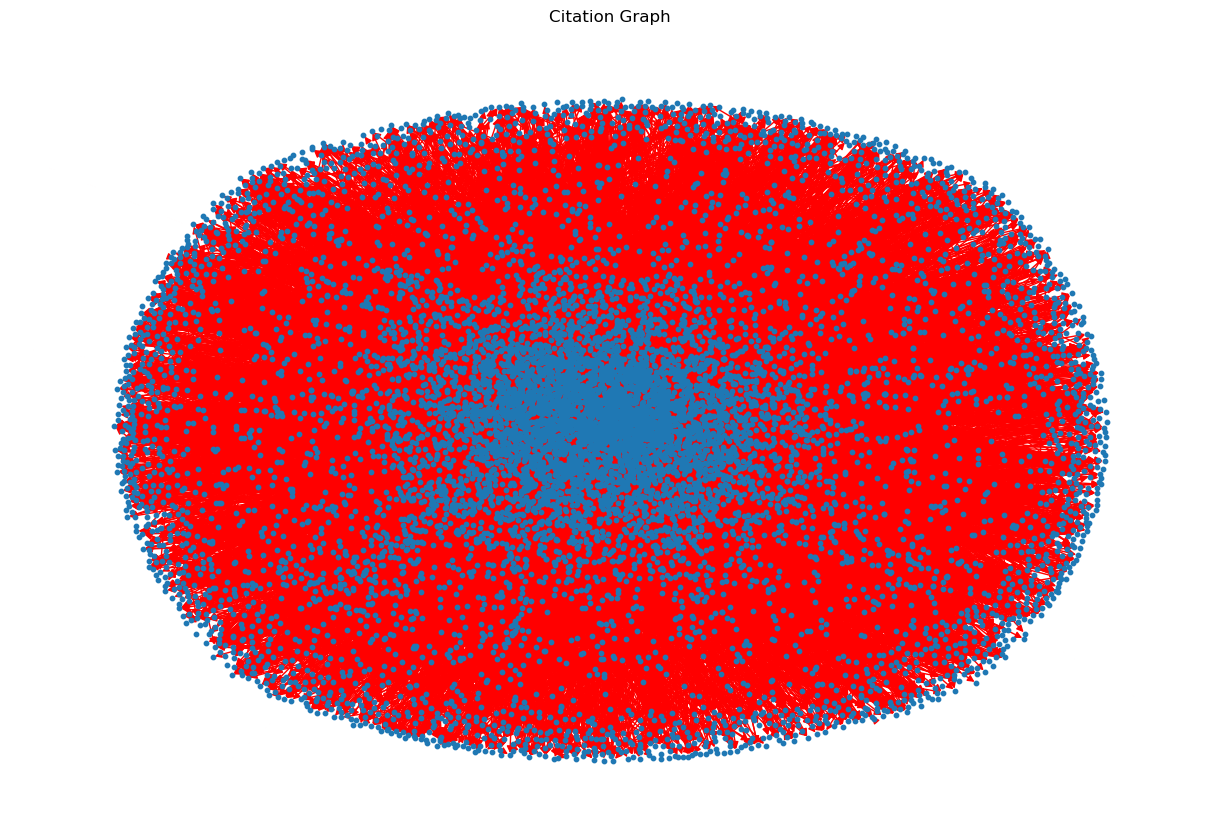

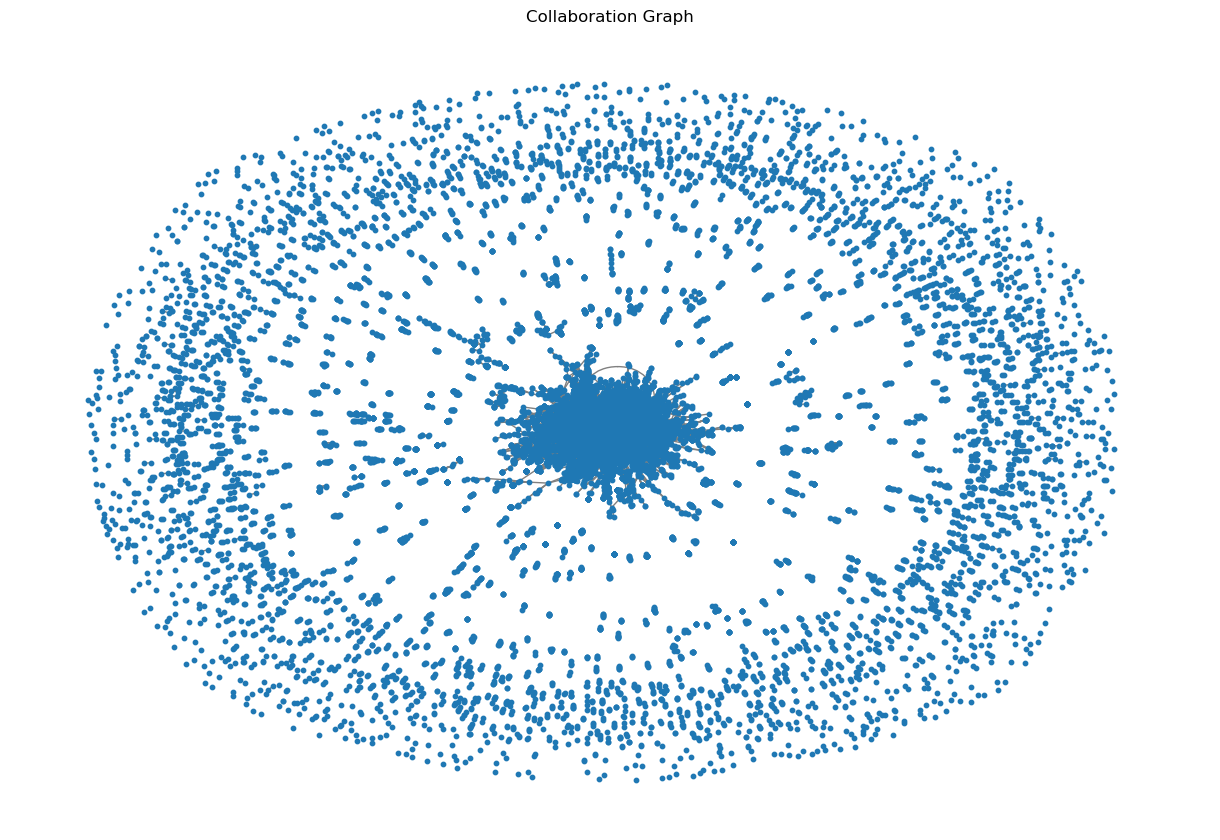

In [10]:
import matplotlib.pyplot as plt

# Visualizing the citation graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(citation_graph)
nx.draw(citation_graph, pos, node_size=10, arrows=True, edge_color='red', with_labels=False)
plt.title("Citation Graph")
plt.show()

# Visualizing the collaboration graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(collaboration_graph)
nx.draw(collaboration_graph, pos, node_size=10, edge_color='gray', with_labels=False)
plt.title("Collaboration Graph")
plt.show()

Visualizing the Largest Connected Component in the Collaboration Graph

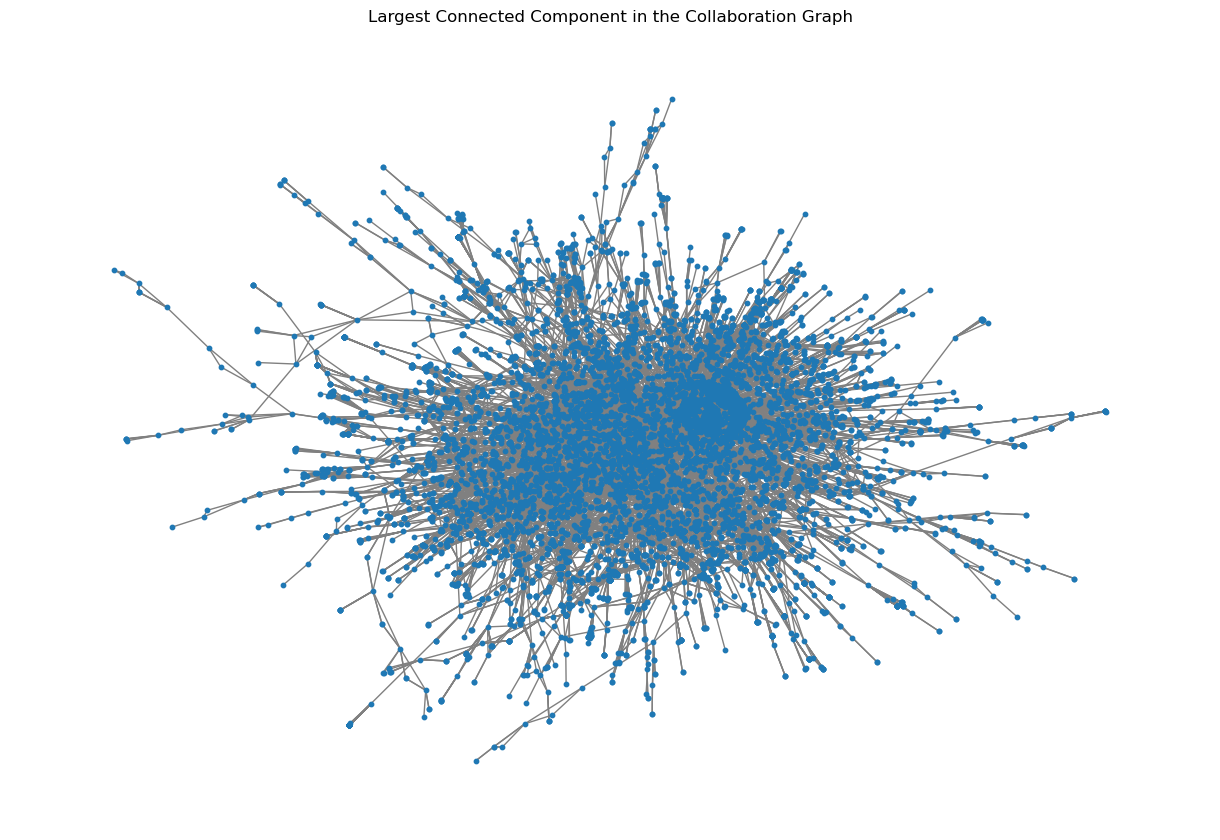

In [12]:
import matplotlib.pyplot as plt

# Visualizing the Largest Connected Component in the Collaboration Graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph_collaboration_graph)
nx.draw(subgraph_collaboration_graph, pos, node_size=10, edge_color='gray', with_labels=False)
plt.title("Largest Connected Component in the Collaboration Graph")
plt.show()

----------